In [1]:
from skimage import io, morphology, color, util, filters, draw
from scipy import stats
import numpy as np
from PIL import Image
import pandas as pd
import sknw

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", palette="Set2")
from IPython.display import display
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

data = "data/"
overview_file = "image_overview.csv"

In [2]:
def calculate_radius(p1, p2, p3):
    # from https://stackoverflow.com/questions/28910718/give-3-points-and-a-plot-circle/50974391#50974391
    temp = p2[0] * p2[0] + p2[1] * p2[1]
    bc = (p1[0] * p1[0] + p1[1] * p1[1] - temp) / 2
    cd = (temp - p3[0] * p3[0] - p3[1] * p3[1]) / 2
    det = (p1[0] - p2[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p2[1])

    if abs(det) < 1.0e-6:
        return None

    # Center of circle
    cx = (bc*(p2[1] - p3[1]) - cd*(p1[1] - p2[1])) / det
    cy = ((p1[0] - p2[0]) * cd - (p2[0] - p3[0]) * bc) / det

    radius = np.sqrt((cx - p1[0])**2 + (cy - p1[1])**2)
    return radius

def calculate_curvatures(points, dist=10):
    
    curvatures_all = list()
    
    for i in range(len(ps)):

        cur_curvatures = list()
        cur_line = ps[i]

        for i in range(dist, len(cur_line[:,0])-dist):

            xm1, x, xp1 = cur_line[i-dist,0], cur_line[i,0], cur_line[i+dist,0]
            ym1, y, yp1 = cur_line[i-dist,1], cur_line[i,1], cur_line[i+dist,1]

            r = calculate_radius((xm1, ym1), (x,y), (xp1, yp1))
            if r is not None:
                cur_curvatures.append(1/r)
                
        curvatures_all.extend(cur_curvatures)
    
    if len(curvatures_all) != 0:
        return curvatures_all
    else:
        return None
    
def calculate_angles(graph, n_points = 10, n_min = 10):

    nodes = graph.nodes()
    angles = list()

    for i in nodes:

        if len(graph.edges(i)) != 3:
            continue

        neighbors_idx = [j for j in graph.neighbors(i)]
        neighbors_pts = np.array([graph[i][j]['pts'] for j in neighbors_idx])
        neighbors_len = [len(j) for j in neighbors_pts]

        if sum(np.array(neighbors_len) > n_min) != 3:
            continue

        c = graph.nodes(data=True)[i]["o"]

        # find closest n points
        p = [0, 0, 0]
        for i in range(3):
            p[i] = neighbors_pts[i][np.argsort(np.sum((neighbors_pts[i] - c)**2, axis=1))[:n_points],:]

        # linear regression through all sets
        sets = [[0,1], [1,2], [0,2]]
        r_vals = list()
        for i in range(3):
            a, b = sets[i][0], sets[i][1]
            temp_data = np.concatenate((p[a], p[b]), axis=0)

            _, _, r_value, _, _ = stats.linregress(temp_data)
            r_squared = r_value**2

            r_vals.append(r_squared)

        best_idx = sets[np.argmax(r_vals)]
        last_idx = list(set([0,1,2]).difference(set(best_idx)))[0]

        # create two lines, one through two best sets and one through last set. 
        temp_data = np.concatenate((p[best_idx[0]], p[best_idx[1]]), axis=0)
        slope1, _, _, _, _ = stats.linregress(temp_data)
        slope2, _, _, _, _ = stats.linregress(p[last_idx][:,0], p[last_idx][:,1])
        
        if np.isnan(slope1): slope1=1000
        if np.isnan(slope2): slope2=1000

        alpha, beta = np.arctan(slope1)*180/3.14, np.arctan(slope2)*180/3.14
        angle = alpha - beta
        #angle = (m1 - m2)*180/3.14
        if angle < 0:
            angle = -angle
        if angle > 90:
            angle = 180 - angle
        if np.isnan(angle):
            angle = 90

        angles.append(angle)
        
    return angles

def box_fractal_dim(img):
    
    convex_hull = morphology.convex_hull_image(img)
    
    return np.sum(img)/np.sum(convex_hull)

In [3]:
img_overview = pd.read_csv(data+overview_file)
img_overview

,img_index,input_img_fname,target_img_fname,binary_threshold,segmentation_fname,gene
0,0,0_brightfield.jpg,0_fluorescence.jpg,15,0_target.png,wt
1,1,1_brightfield.jpg,1_fluorescence.jpg,25,1_target.png,wt
2,2,2_brightfield.jpg,2_fluorescence.jpg,15,2_target.png,wt
3,3,3_brightfield.jpg,3_fluorescence.jpg,25,3_target.png,wt
4,4,4_brightfield.jpg,4_fluorescence.jpg,15,4_target.png,wt
5,5,5_brightfield.jpg,5_fluorescence.jpg,25,5_target.png,wt
6,6,6_brightfield.jpg,6_fluorescence.jpg,15,6_target.png,wt
7,9,9_brightfield_chsC.jpg,9_fluorescence_chsC.jpg,20,9_target.png,chsc
8,10,10a_brightfield_chsC.png,10a_fluorescence_chsC.png,25,10a_target.jpg,chsc
9,11,10b_brightfield_chsC.png,10b_fluorescence_chsC.png,25,10b_target.jpg,chsc


In [82]:
branching_freqs = list()
curvatures_all = list()
angles_all = list()
internodal_all = list()
box_counting_dims_all = list()

pixels_per_hyphal_element = 50

n_hours = 24

for idx in range(0, 1):

    fl_fname = img_overview.at[idx, "target_img_fname"]
    fl_img  = io.imread(data + fl_fname)
    fl_img = fl_img[:,:,2]
    fl_img = util.img_as_ubyte(fl_img)
    
    
    threshold = img_overview.at[idx, "binary_threshold"]

    bin_img = fl_img.copy()
    bin_img[bin_img >= threshold] = 255
    bin_img[bin_img < threshold] = 0

    bin_img = bin_img.astype(np.bool)

    bin_img = morphology.remove_small_objects(bin_img, min_size=10000, connectivity=2)

    filter_bin_img = filters.median(bin_img, selem=morphology.square(5))

    ske_img = morphology.skeletonize(filter_bin_img)
    ske_img = morphology.remove_small_objects(ske_img, min_size=1000, connectivity=2)
    
    # build graph from skeleton
    graph = sknw.build_sknw(ske_img)

    # draw node by o
    nodes = graph.nodes()
    bs = np.array([nodes[i]['o'] for i in nodes if len(graph.edges(i))>=3])
    ts = np.array([nodes[i]['o'] for i in nodes if len(graph.edges(i))<=2])
    
    ps = list()
    internodal_lengths = list()

    for (s,e) in graph.edges():
        ps.append(graph[s][e]['pts'].astype(np.int32))
        
        if len([j for j in graph.neighbors(s)]) == 3 and len([j for j in graph.neighbors(s)]) == 3:
            internodal_lengths.append(len(graph[s][e]['pts'].astype(np.int32)))
        
    curvatures = calculate_curvatures(ps)
        
    branch_occurence = (len(bs))/graph.size(weight="weight")    
    n_hyphal_elements = (graph.size(weight="weight"))/pixels_per_hyphal_element
    
    curvatures_all.append(curvatures)
    branching_freqs.append(branch_occurence*pixels_per_hyphal_element/24)
    
    angles = calculate_angles(graph)
    angles_all.append(angles)
    
    internodal_all.append(internodal_lengths)
    
    box_counting_dims_all.append(box_fractal_dim(ske_img))
 
    
    


# Branching frequency

In [7]:
branching_freqs

[0.0157585996329121]

In [6]:
img_overview["branching_freqs"] = branching_freqs
img_overview["box_counting_dim"] = box_counting_dims_all
img_overview["mean_curvature"] = [np.mean(x) for x in curvatures_all]
img_overview["mean_angle"] = [np.mean(x) for x in angles_all]
img_overview

ValueError: Length of values (1) does not match length of index (36)

In [ ]:
f, ax = plt.subplots()

sns.barplot(data=img_overview, x="gene", y="branching_freqs", alpha=0.5, ci=False, ax=ax)
sns.stripplot(data=img_overview, x="gene", hue="gene", y="branching_freqs", edgecolor="k", ax=ax, linewidth=0.5)

In [ ]:
f, ax = plt.subplots()

sns.barplot(data=img_overview, x="gene", y="box_counting_dim", alpha=0.5, ci=False, ax=ax)
sns.stripplot(data=img_overview, x="gene", hue="gene", y="box_counting_dim", edgecolor="k", ax=ax, linewidth=0.5)

In [ ]:
f, ax = plt.subplots()

sns.barplot(data=img_overview, x="gene", y="mean_curvature", alpha=0.5, ci=False, ax=ax)
sns.stripplot(data=img_overview, x="gene", hue="gene", y="mean_curvature", edgecolor="k", ax=ax, linewidth=0.5)

In [ ]:
f, ax = plt.subplots()

sns.barplot(data=img_overview, x="gene", y="mean_angle", alpha=0.5, ci=False, ax=ax)
sns.stripplot(data=img_overview, x="gene", hue="gene", y="mean_angle", edgecolor="k", ax=ax, linewidth=0.5)

In [ ]:
img_overview["mean_curvature"] = [np.mean(x) for x in curvatures_all]
img_overview

# Angles

In [8]:
angle_df = img_overview.copy()
angle_df["angles"] = angles_all
angle_df = angle_df.loc[:, ["gene", "angles"]]
angle_df = angle_df.explode('angles')

angle_df["angles"] = angle_df["angles"].astype(float)

g = sns.FacetGrid(data=angle_df, col="gene", xlim=(0, 90))
g.map(sns.distplot, "angles")

ValueError: Length of values (1) does not match length of index (36)

In [9]:
angle_df["angles"] = angle_df["angles"].astype(float)

KeyError: 'angles'

In [ ]:
g = sns.FacetGrid(data=angle_df, col="gene", xlim=(0, 90))
g.map(sns.distplot, "angles")

# Curvatures

In [10]:
curv_df = img_overview.copy()
curv_df["curvatures"] = curvatures_all

curv_df = curv_df.loc[:, ["img_index", "gene", "curvatures"]]

curv_df = curv_df.explode('curvatures')
curv_df["curvatures"] = curv_df["curvatures"].astype(float)
curv_df

ValueError: Length of values (1) does not match length of index (36)

In [ ]:
g = sns.FacetGrid(data=curv_df, col="gene", xlim=(0.01, max(curv_df["curvatures"])))
g.map(sns.distplot, "curvatures", 
      bins=np.arange(0.01, max(curv_df["curvatures"]), (max(curv_df["curvatures"])+0.01)/20))

In [ ]:
curv_df["curvatures"].reset_index(drop=True)

# Angle estimations and plot

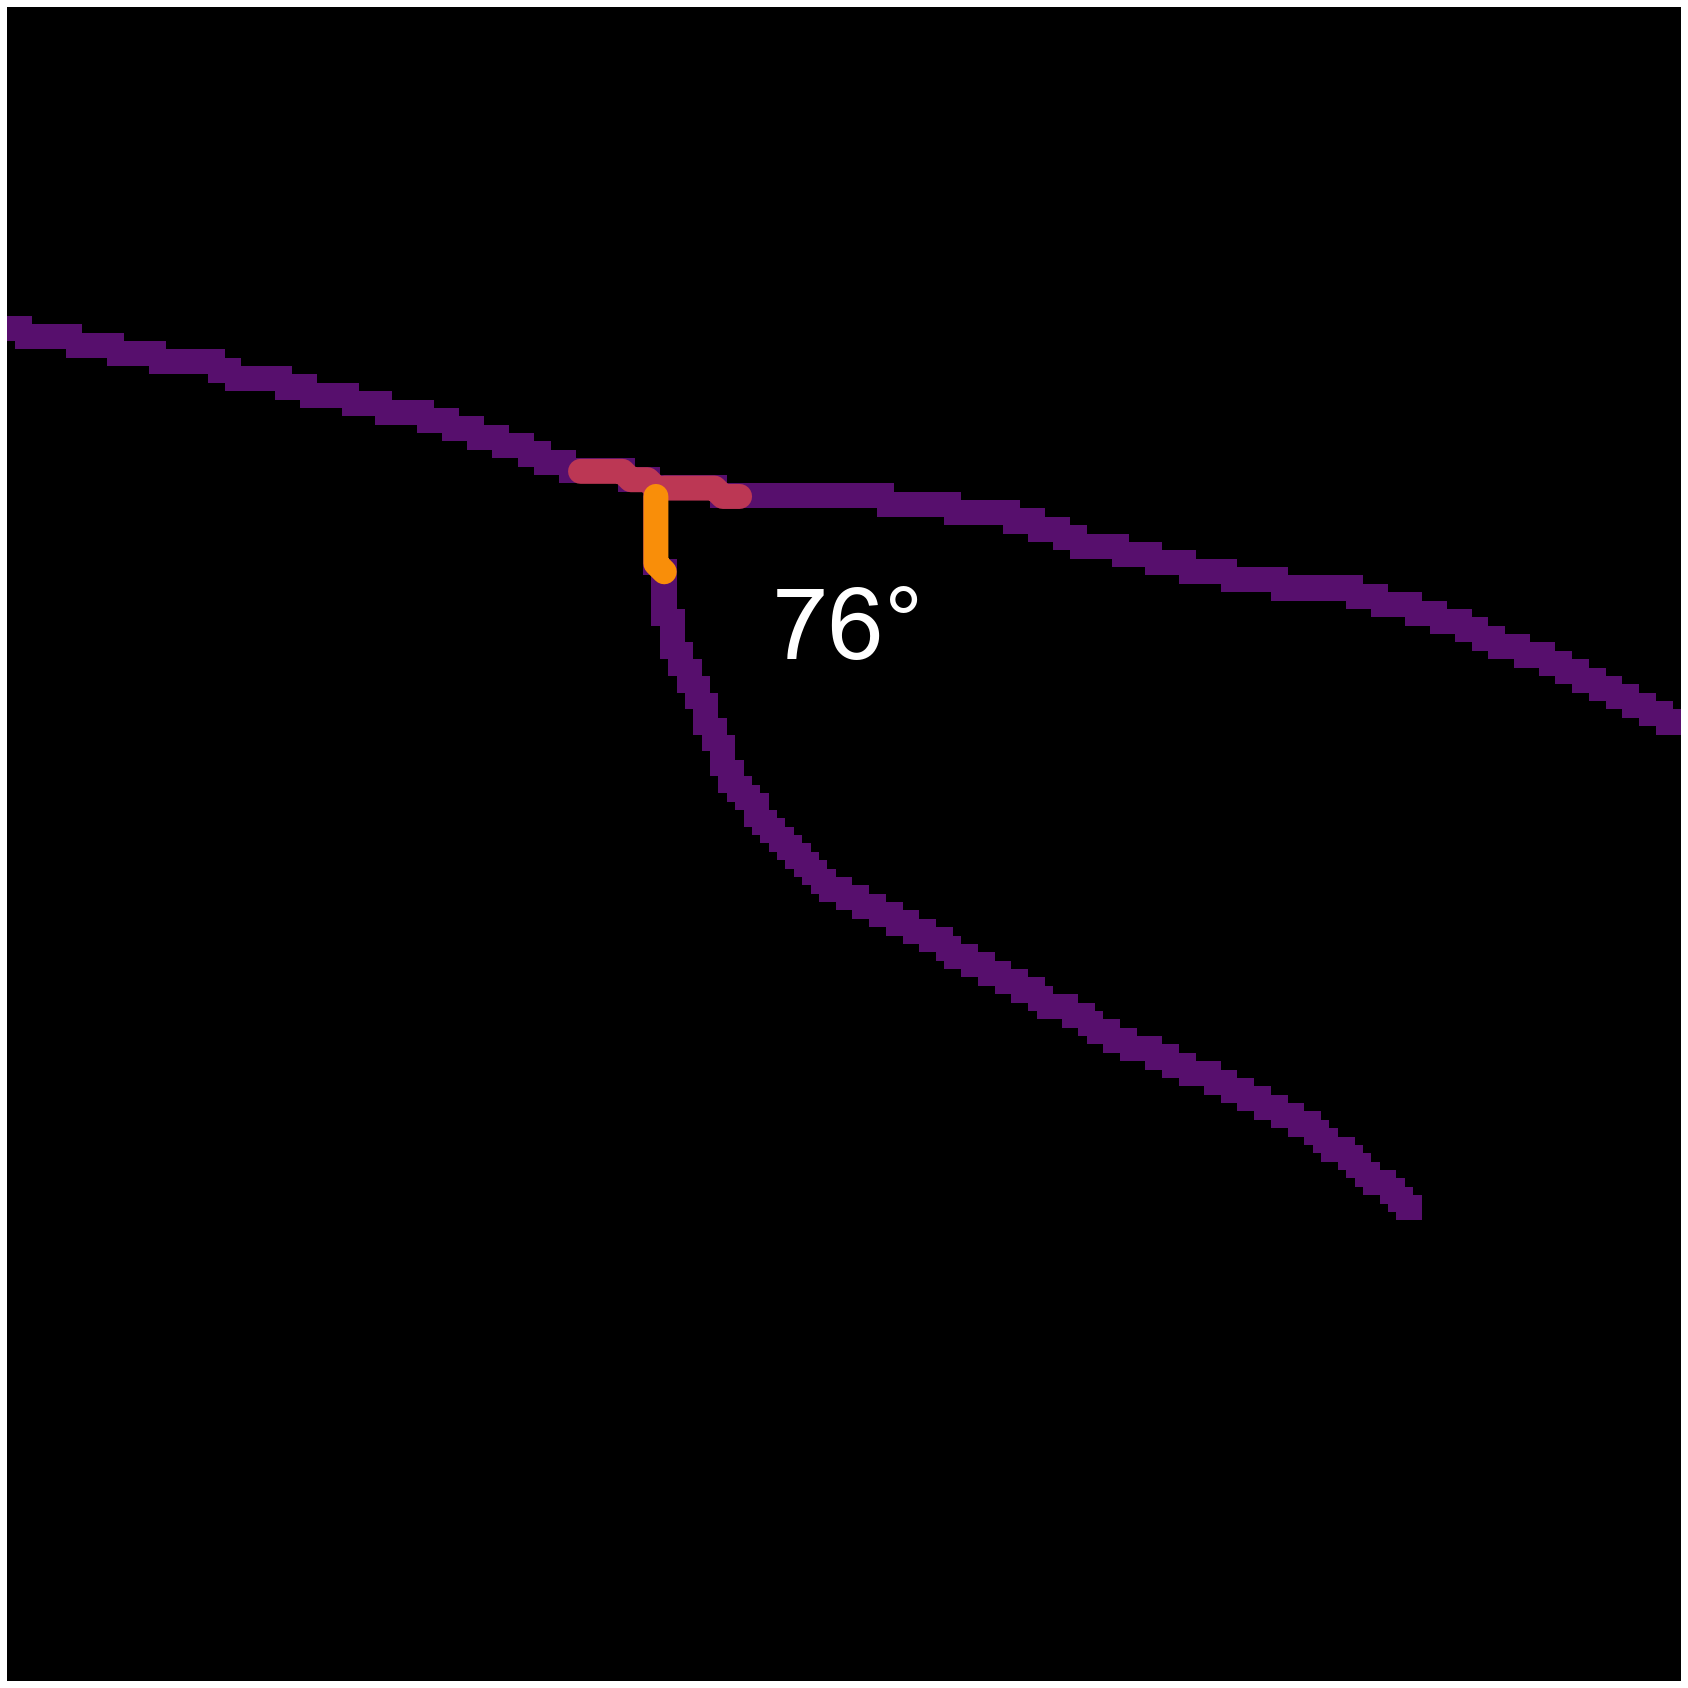

In [63]:
f, ax = plt.subplots(figsize=[30,40])
import matplotlib

ske_small = ske_img[3500:3700, 2850:3050]
colors = sns.color_palette("inferno", 3)

graph = sknw.build_sknw(ske_small)

nodes = graph.nodes()
angles = list()

n_points = 10
n_min = 10

for i in nodes:
    
    if len(graph.edges(i)) != 3:
        continue
    
    neighbors_idx = [j for j in graph.neighbors(i)]
    neighbors_pts = np.array([graph[i][j]['pts'] for j in neighbors_idx])
    neighbors_len = [len(j) for j in neighbors_pts]
    
    if sum(np.array(neighbors_len) > n_min) != 3:
        continue
    
    c = graph.nodes(data=True)[i]["o"]
    
    # find closest 5 points
    p = [0, 0, 0]
    for i in range(3):
        p[i] = neighbors_pts[i][np.argsort(np.sum((neighbors_pts[i] - c)**2, axis=1))[:n_points],:]
        
    # linear regression through all sets
    sets = [[0,1], [1,2], [0,2]]
    r_vals = list()
    for i in range(3):
        a, b = sets[i][0], sets[i][1]
        temp_data = np.concatenate((p[a], p[b]), axis=0)
        
        _, _, r_value, _, _ = stats.linregress(temp_data)
        r_squared = r_value**2
        
        r_vals.append(r_squared)
        
        
        
        
    
    best_idx = sets[np.argmax(r_vals)]
    last_idx = list(set([0,1,2]).difference(set(best_idx)))[0]
    
    # create two lines, one through two best sets and one through last set. 
    temp_data = np.concatenate((p[best_idx[0]], p[best_idx[1]]), axis=0)
    slope1, _, _, _, _ = stats.linregress(temp_data)
    slope2, _, _, _, _ = stats.linregress(p[last_idx][:,0], p[last_idx][:,1])
    
    alpha, beta = np.arctan(slope1)*180/3.14, np.arctan(slope2)*180/3.14
    angle = alpha - beta
    
    if np.isnan(alpha):
        angle = 90
    if np.isnan(beta):
        angle = 90
    
    #angle = (m1 - m2)*180/3.14
    if angle < 0:
        angle = -angle
    if angle > 90:
        angle = 180 - angle
    
    
    angles.append(angle)
    
    plt.plot(p[best_idx[0]][:, 1], p[best_idx[0]][:, 0], color=colors[1], linewidth=25)
    plt.plot(p[best_idx[1]][:, 1], p[best_idx[1]][:, 0], color=colors[1], linewidth=25)
    plt.plot(p[last_idx][:, 1], p[last_idx][:, 0], color=colors[2], linewidth=25)
    plt.text(c[1]+7, c[0]+20, f"  {angle:.0f}°", fontsize=100, color="w") #angle:.0f
    

ax.set_aspect('equal')
ax.imshow(morphology.binary_dilation(ske_small, selem=morphology.square(3)), 
           cmap = matplotlib.colors.ListedColormap(['black', colors[0]]), interpolation=None)
plt.axis('off')
plt.show()


# Internodal lengths

In [12]:
inter_df = img_overview.copy()
inter_df["internodal"] = internodal_all

inter_df = inter_df.loc[:, ["img_index", "gene", "internodal"]]

inter_df = inter_df.explode('internodal')
inter_df

ValueError: Length of values (1) does not match length of index (36)

In [ ]:
g = sns.FacetGrid(data=inter_df, col="gene", aspect=1, xlim=(0,125))
g.map(sns.distplot, "internodal")



In [ ]:
np.unique(angles_all)

In [20]:
dist = 10
curvatures_example = list()

for i in range(len(ps)):
    
    cur_line = ps[i]
    
    if len(cur_line) <= 2*dist:
        cur_curvatures = [0]*len(cur_line)
    else:
        cur_curvatures = [0]*dist

    for i in range(dist, len(cur_line[:,0])-dist):

        xm1, x, xp1 = cur_line[i-dist,0], cur_line[i,0], cur_line[i+dist,0]
        ym1, y, yp1 = cur_line[i-dist,1], cur_line[i,1], cur_line[i+dist,1]

        r = calculate_radius((xm1, ym1), (x,y), (xp1, yp1))
        if r is not None:
            cur_curvatures.append(1/r)
        else:
            cur_curvatures.append(0)
    
    if len(cur_line) > 2*dist:
        cur_curvatures.extend([0]*dist)
        
    curvatures_example.append(cur_curvatures)
    
max_curvature = max(max(curvatures_example))

for i, l in enumerate(curvatures_example):
    
    for j, v in enumerate(l):
        if v != 0:
            curvatures_example[i][j] = np.minimum(int(v/max_curvature * 255), 255).astype(np.uint8)

In [65]:
curvature_mask = np.zeros(ske_img.shape, dtype=np.uint8)

for i in range(len(ps)):
    cur_line = ps[i]
    
    curvature_mask[cur_line[:, 0], cur_line[:, 1]] = curvatures_example[i]
    
curvature_mask = morphology.dilation(curvature_mask, morphology.disk(3))



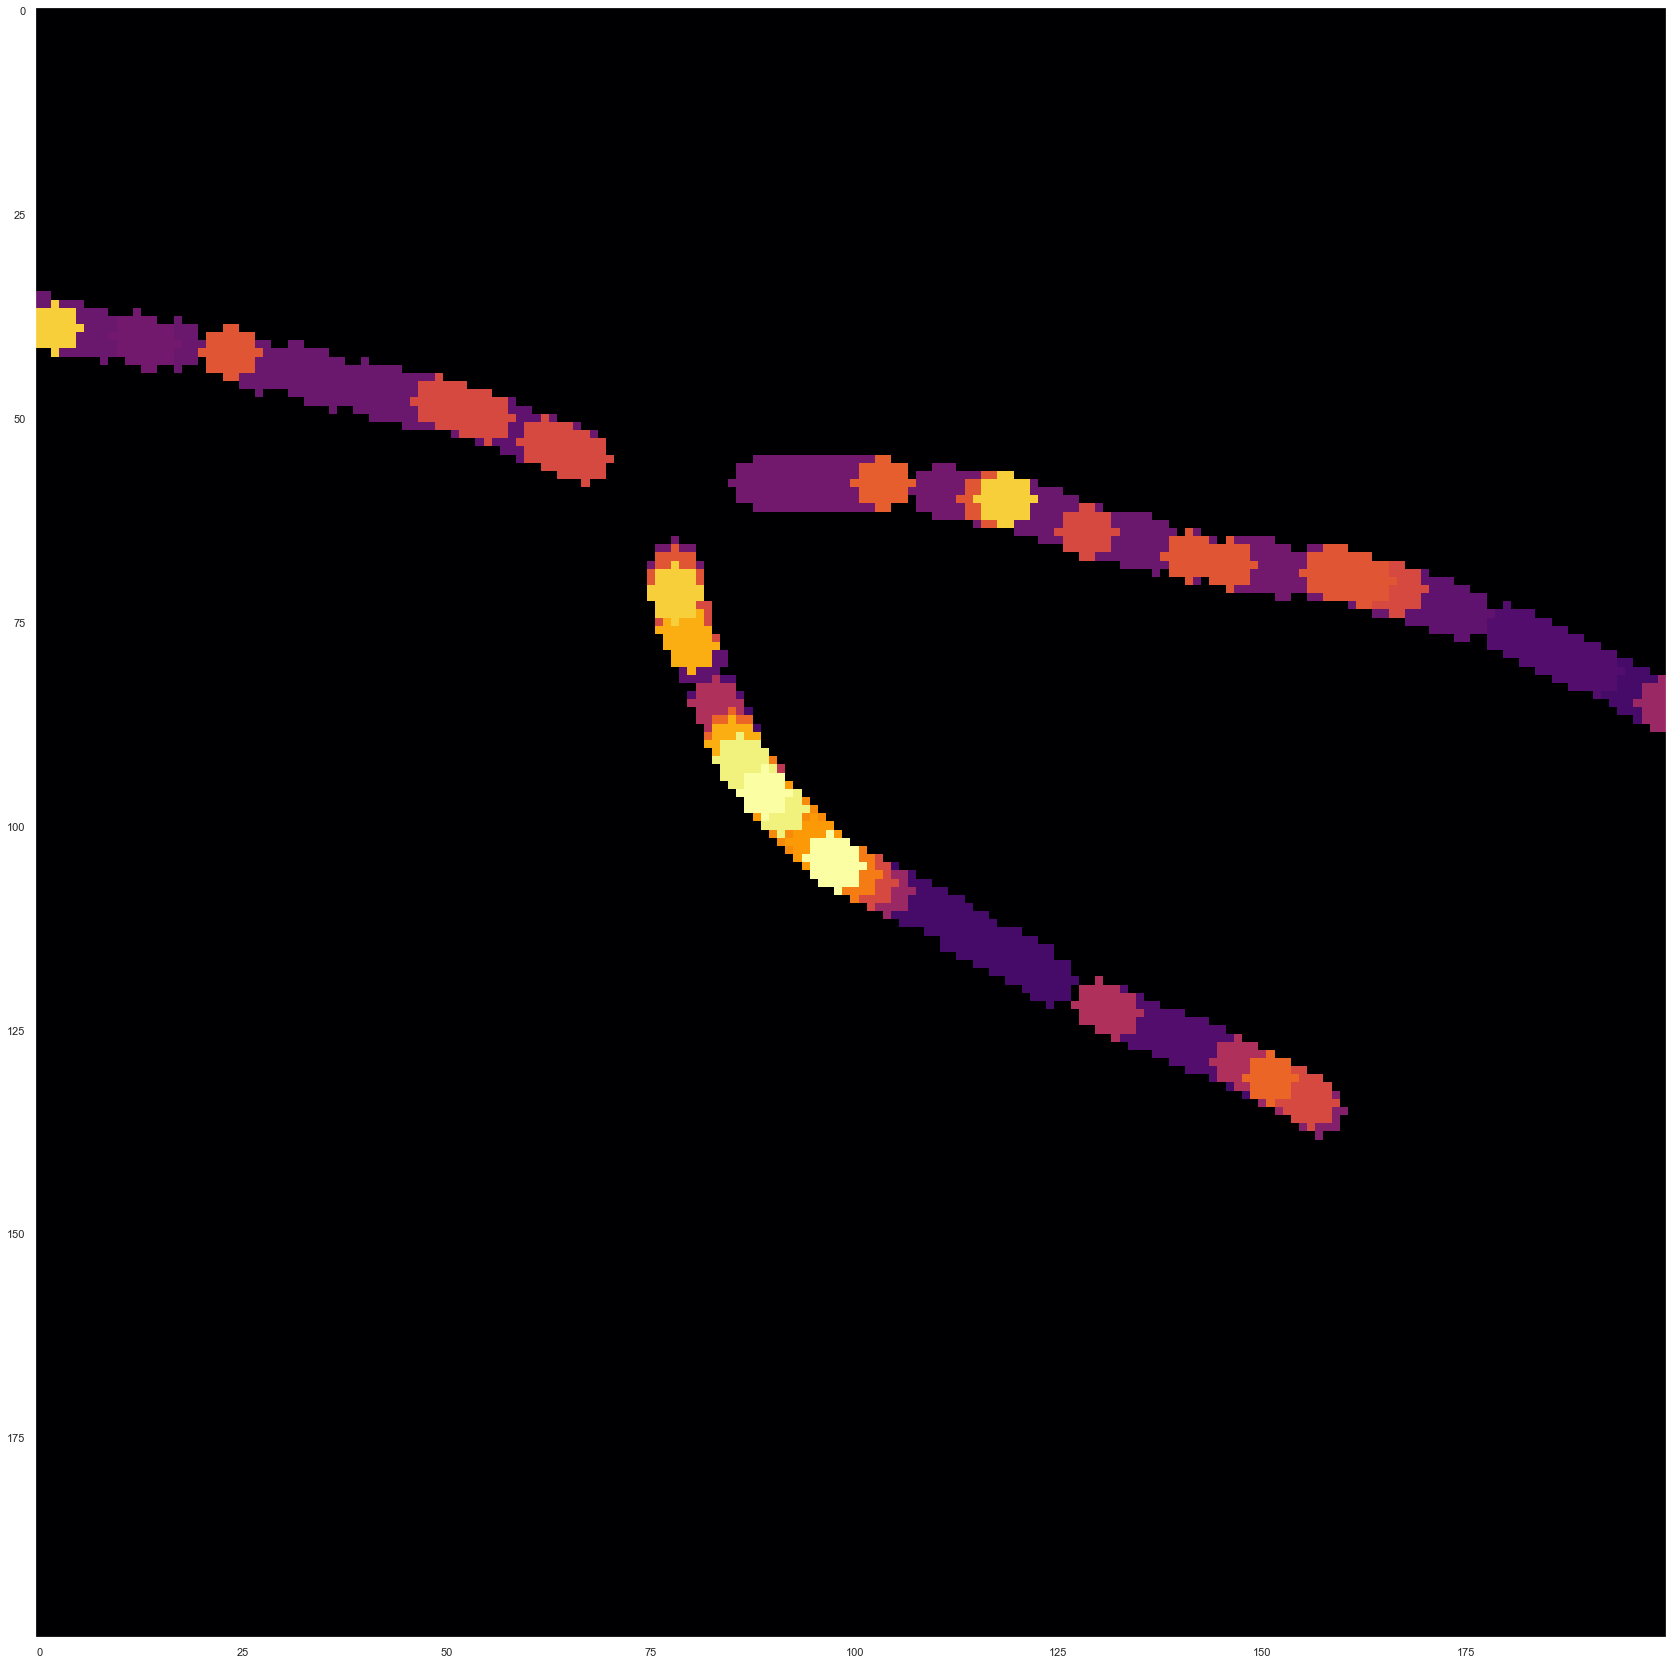

In [68]:
curvature_small = curvature_mask[3500:3700, 2850:3050]
#colors = sns.color_palette("inferno", 3)

f, ax = plt.subplots(figsize=[40,30])

ax.imshow(curvature_small, cmap="inferno", interpolation="none")
plt.grid(None)

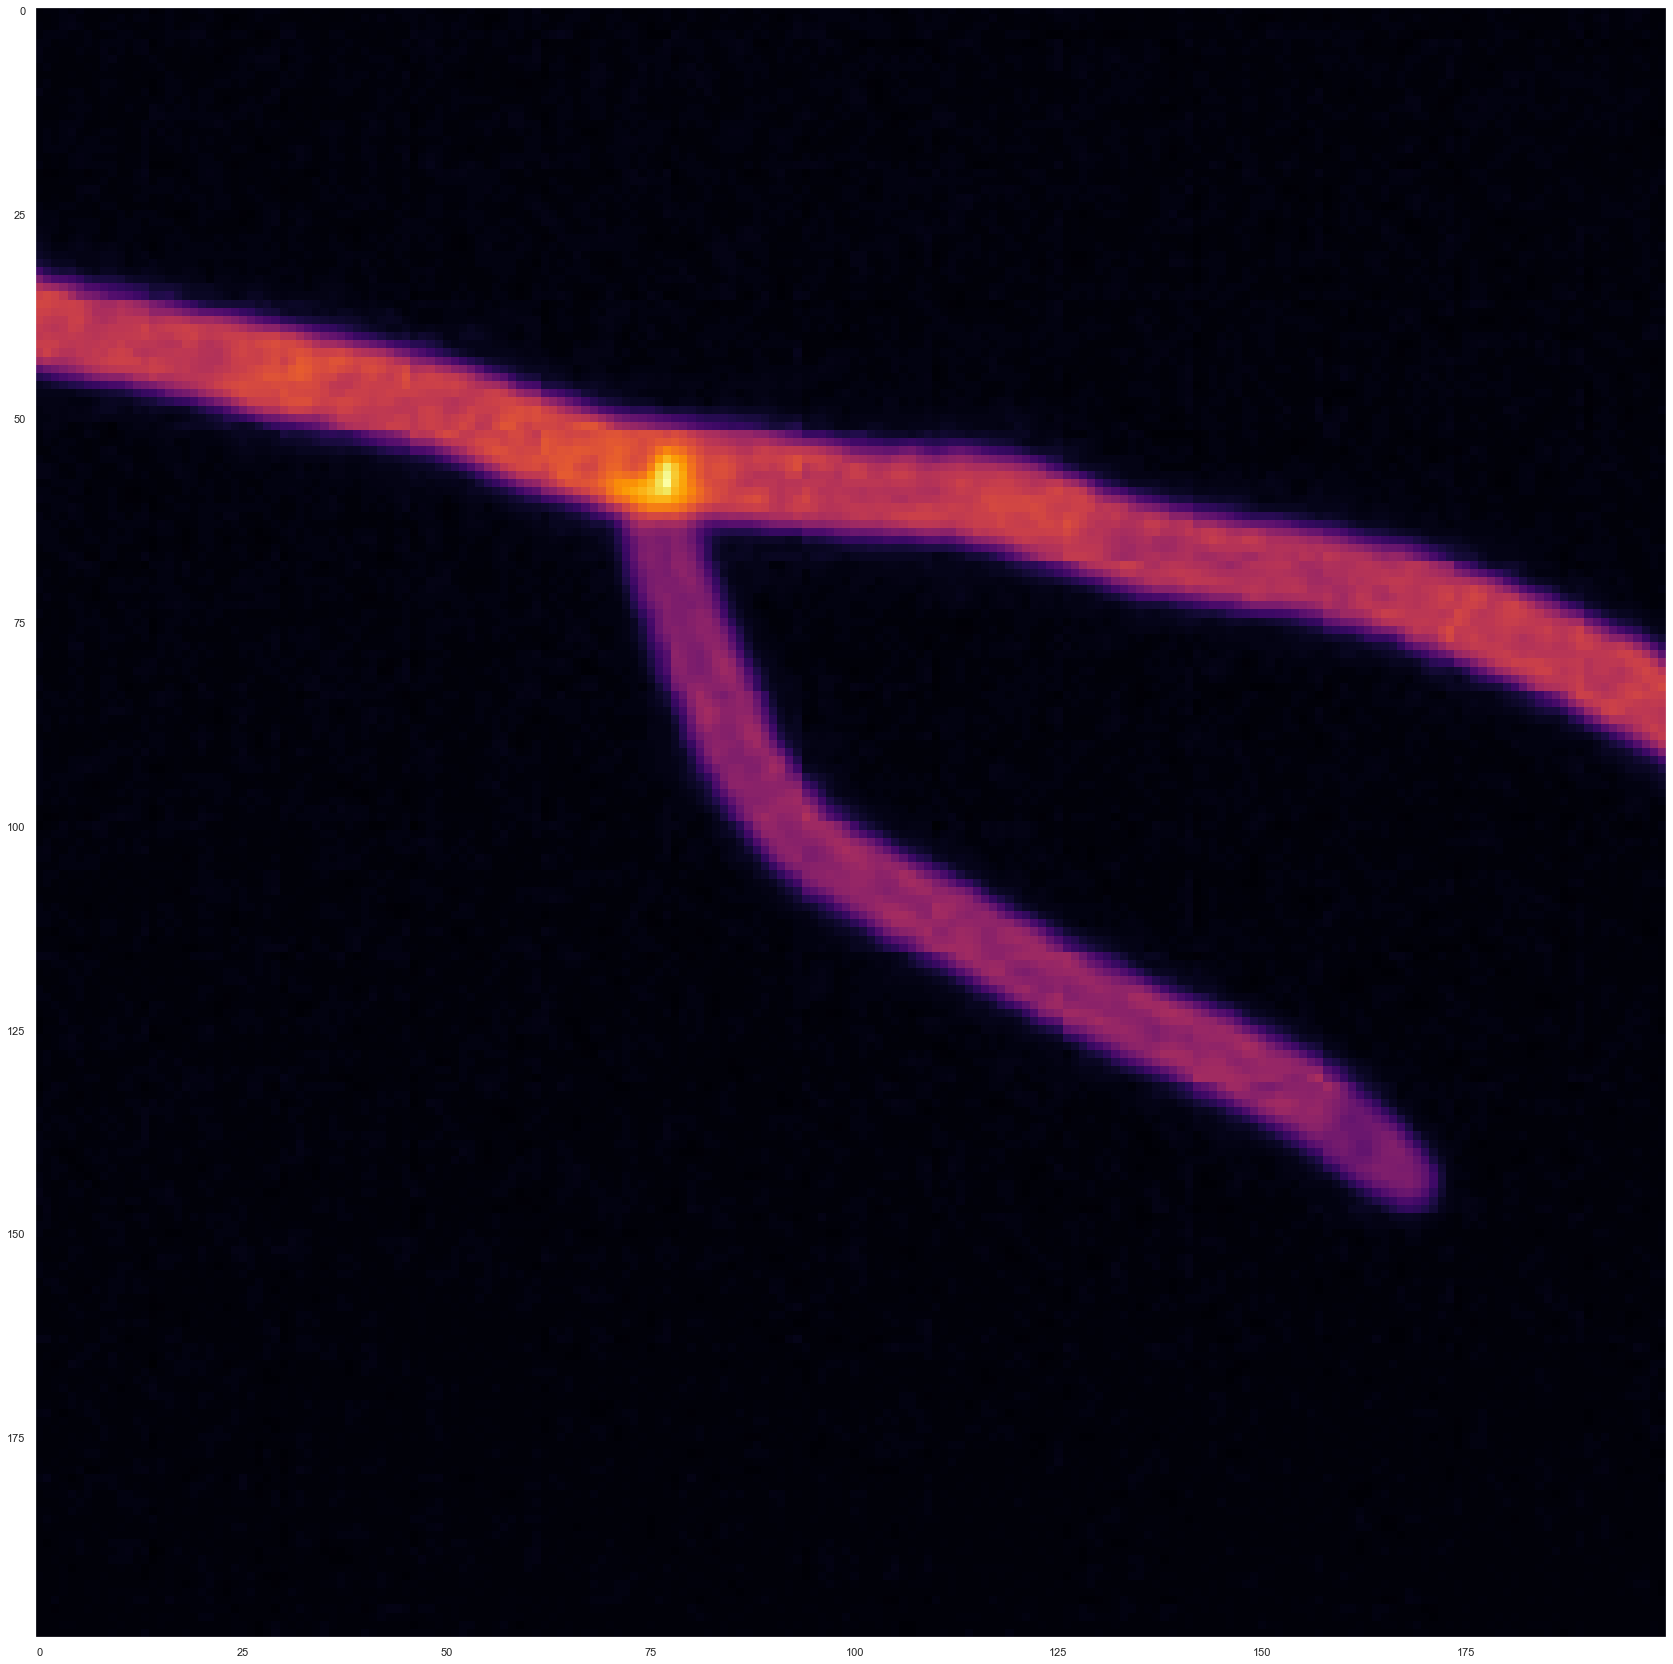

In [71]:
fl_small = fl_img[3500:3700, 2850:3050]

f, ax = plt.subplots(figsize=[40,30])

ax.imshow(fl_small, cmap="inferno", interpolation="none")
plt.grid(None)

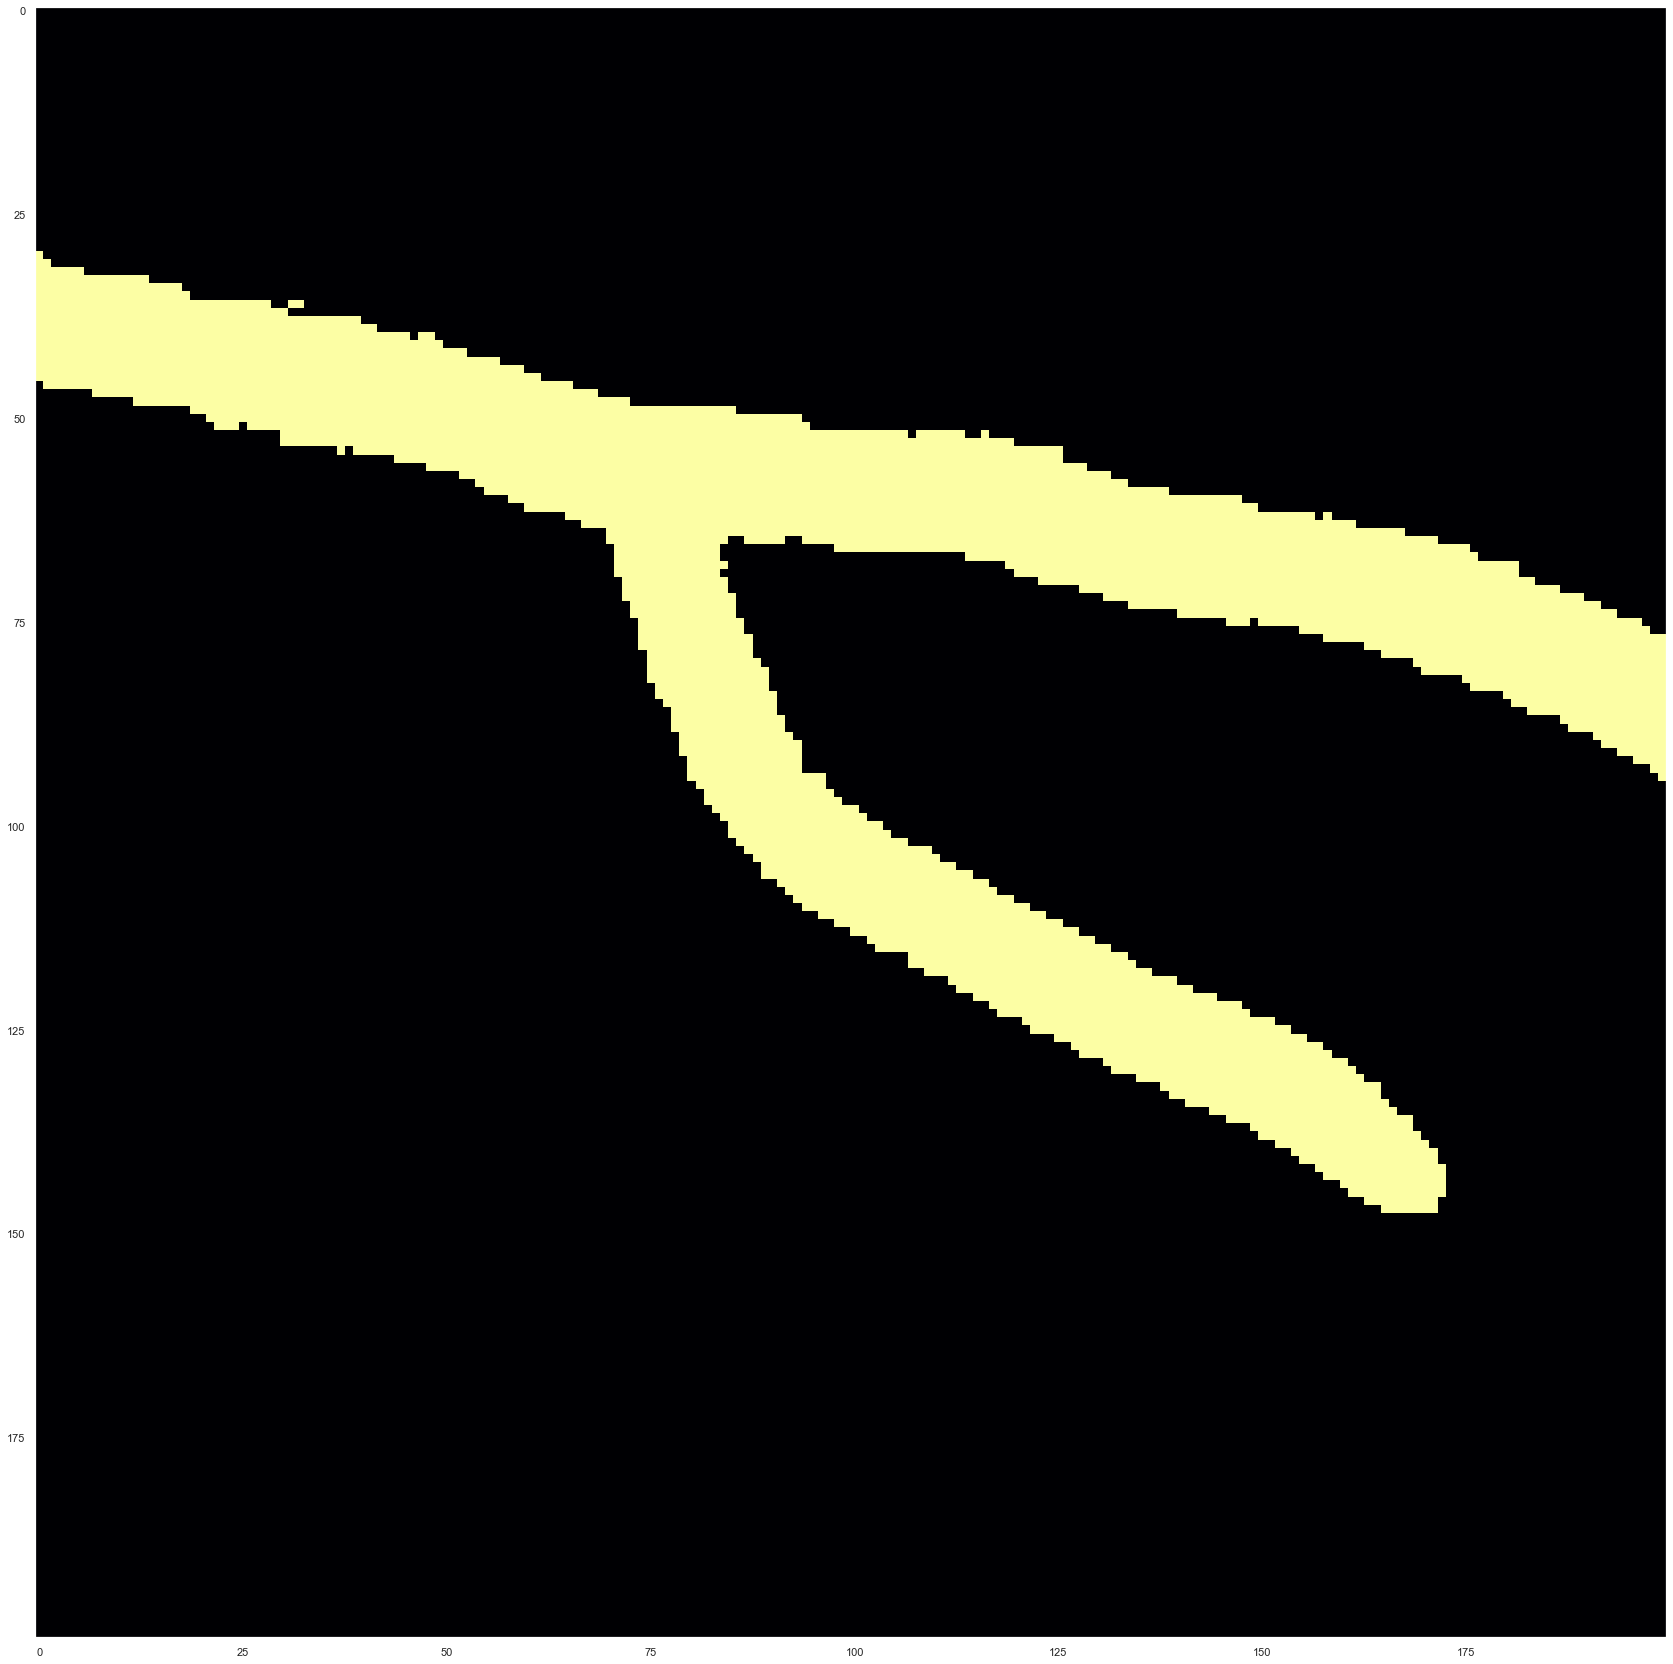

In [83]:
bin_small = bin_img[3500:3700, 2850:3050]

f, ax = plt.subplots(figsize=[40,30])

ax.imshow(bin_small, cmap="inferno", interpolation="none")
plt.grid(None)

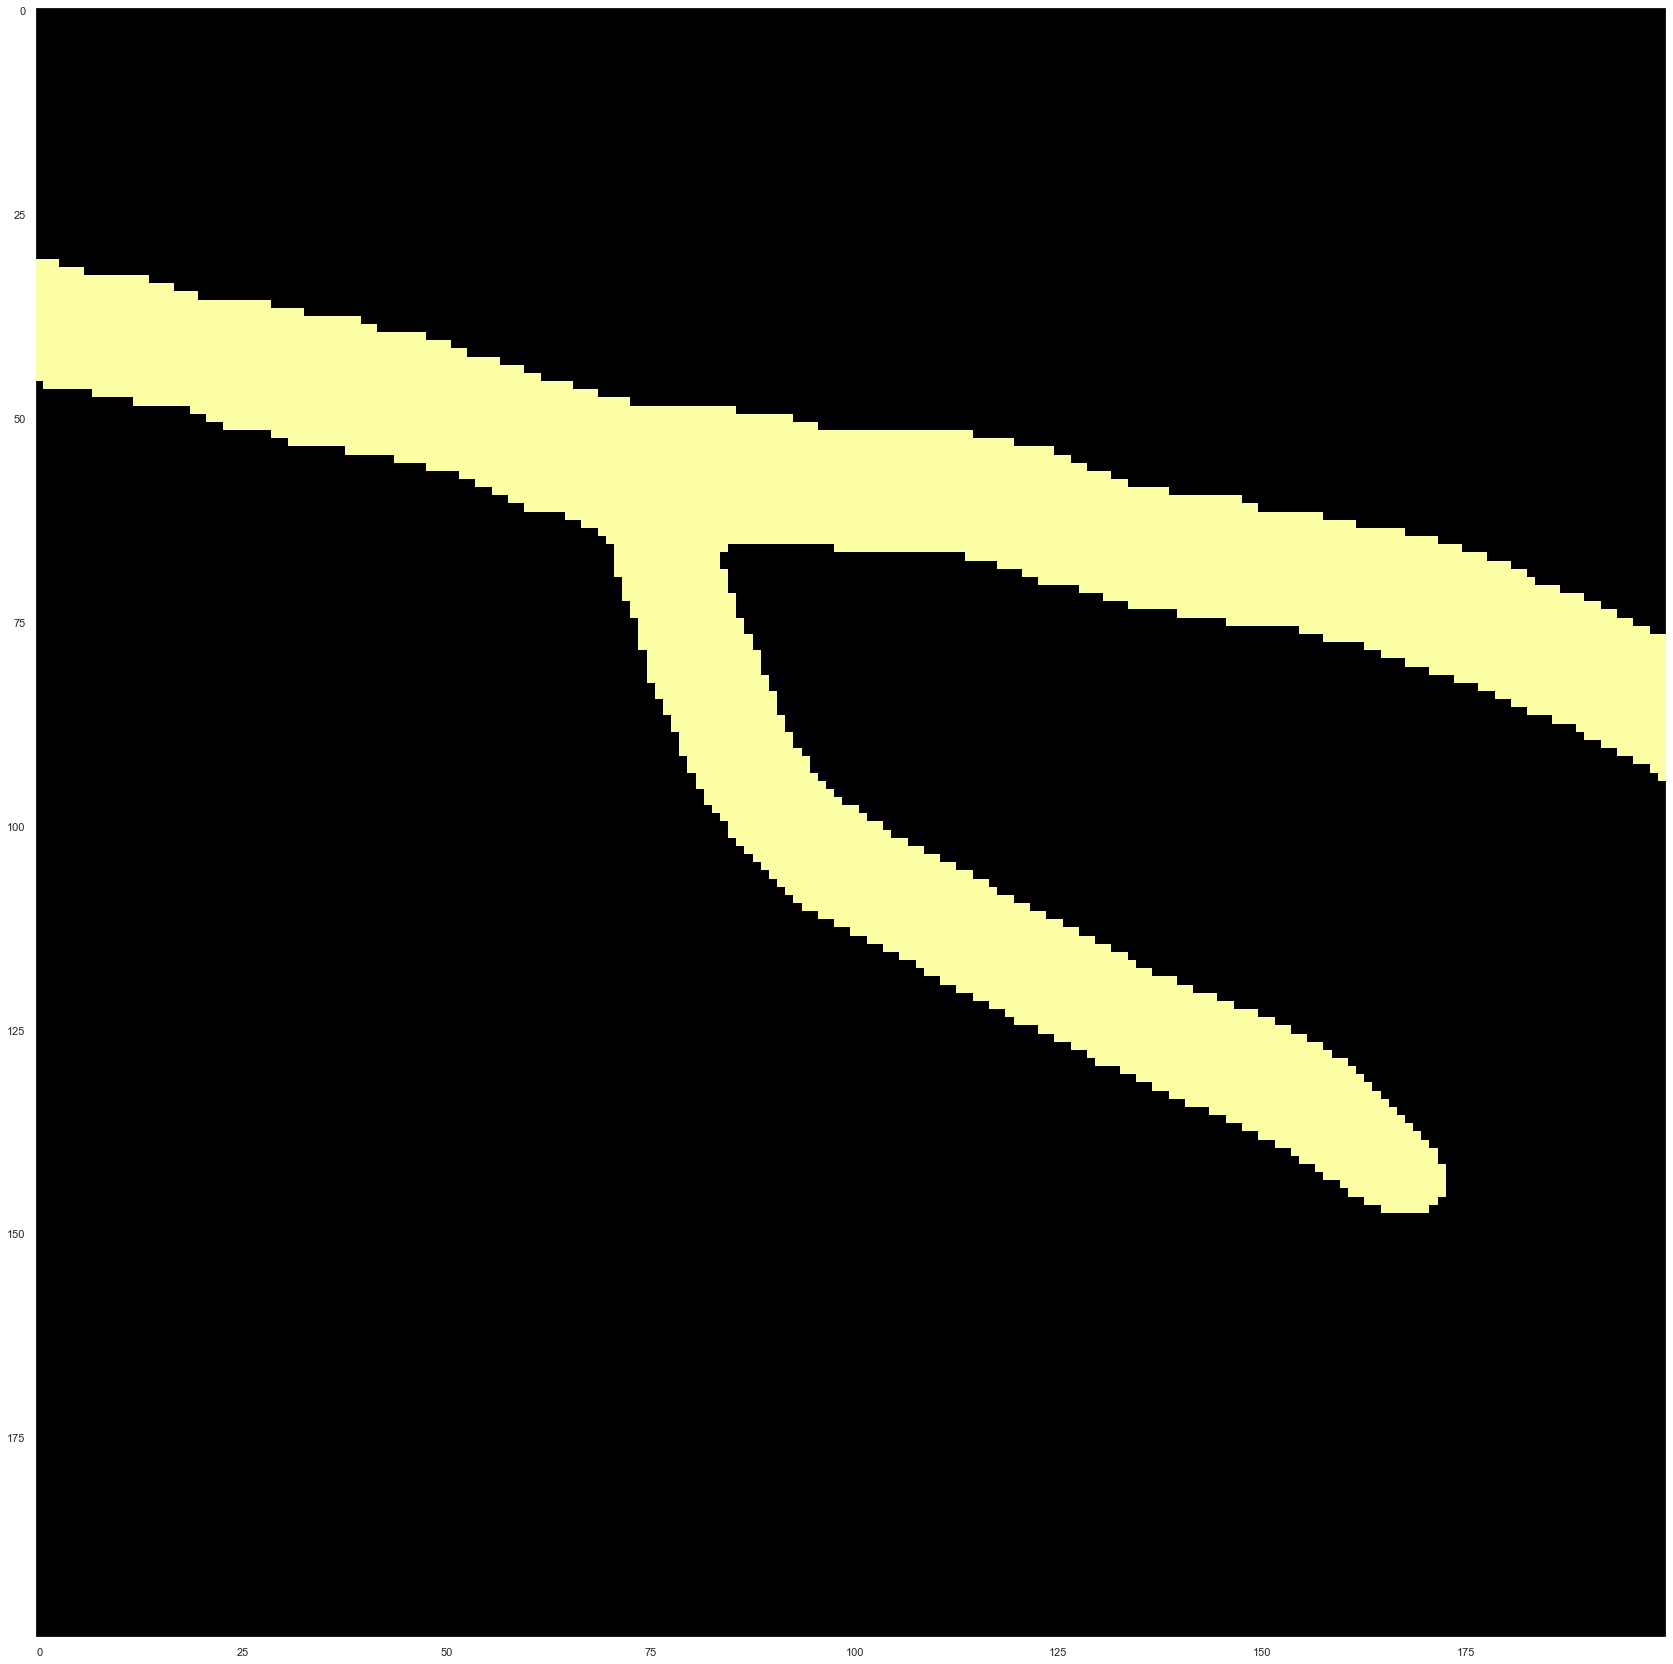

In [84]:
filter_small = filter_bin_img[3500:3700, 2850:3050]

f, ax = plt.subplots(figsize=[40,30])

ax.imshow(filter_small, cmap="inferno", interpolation="none")
plt.grid(None)

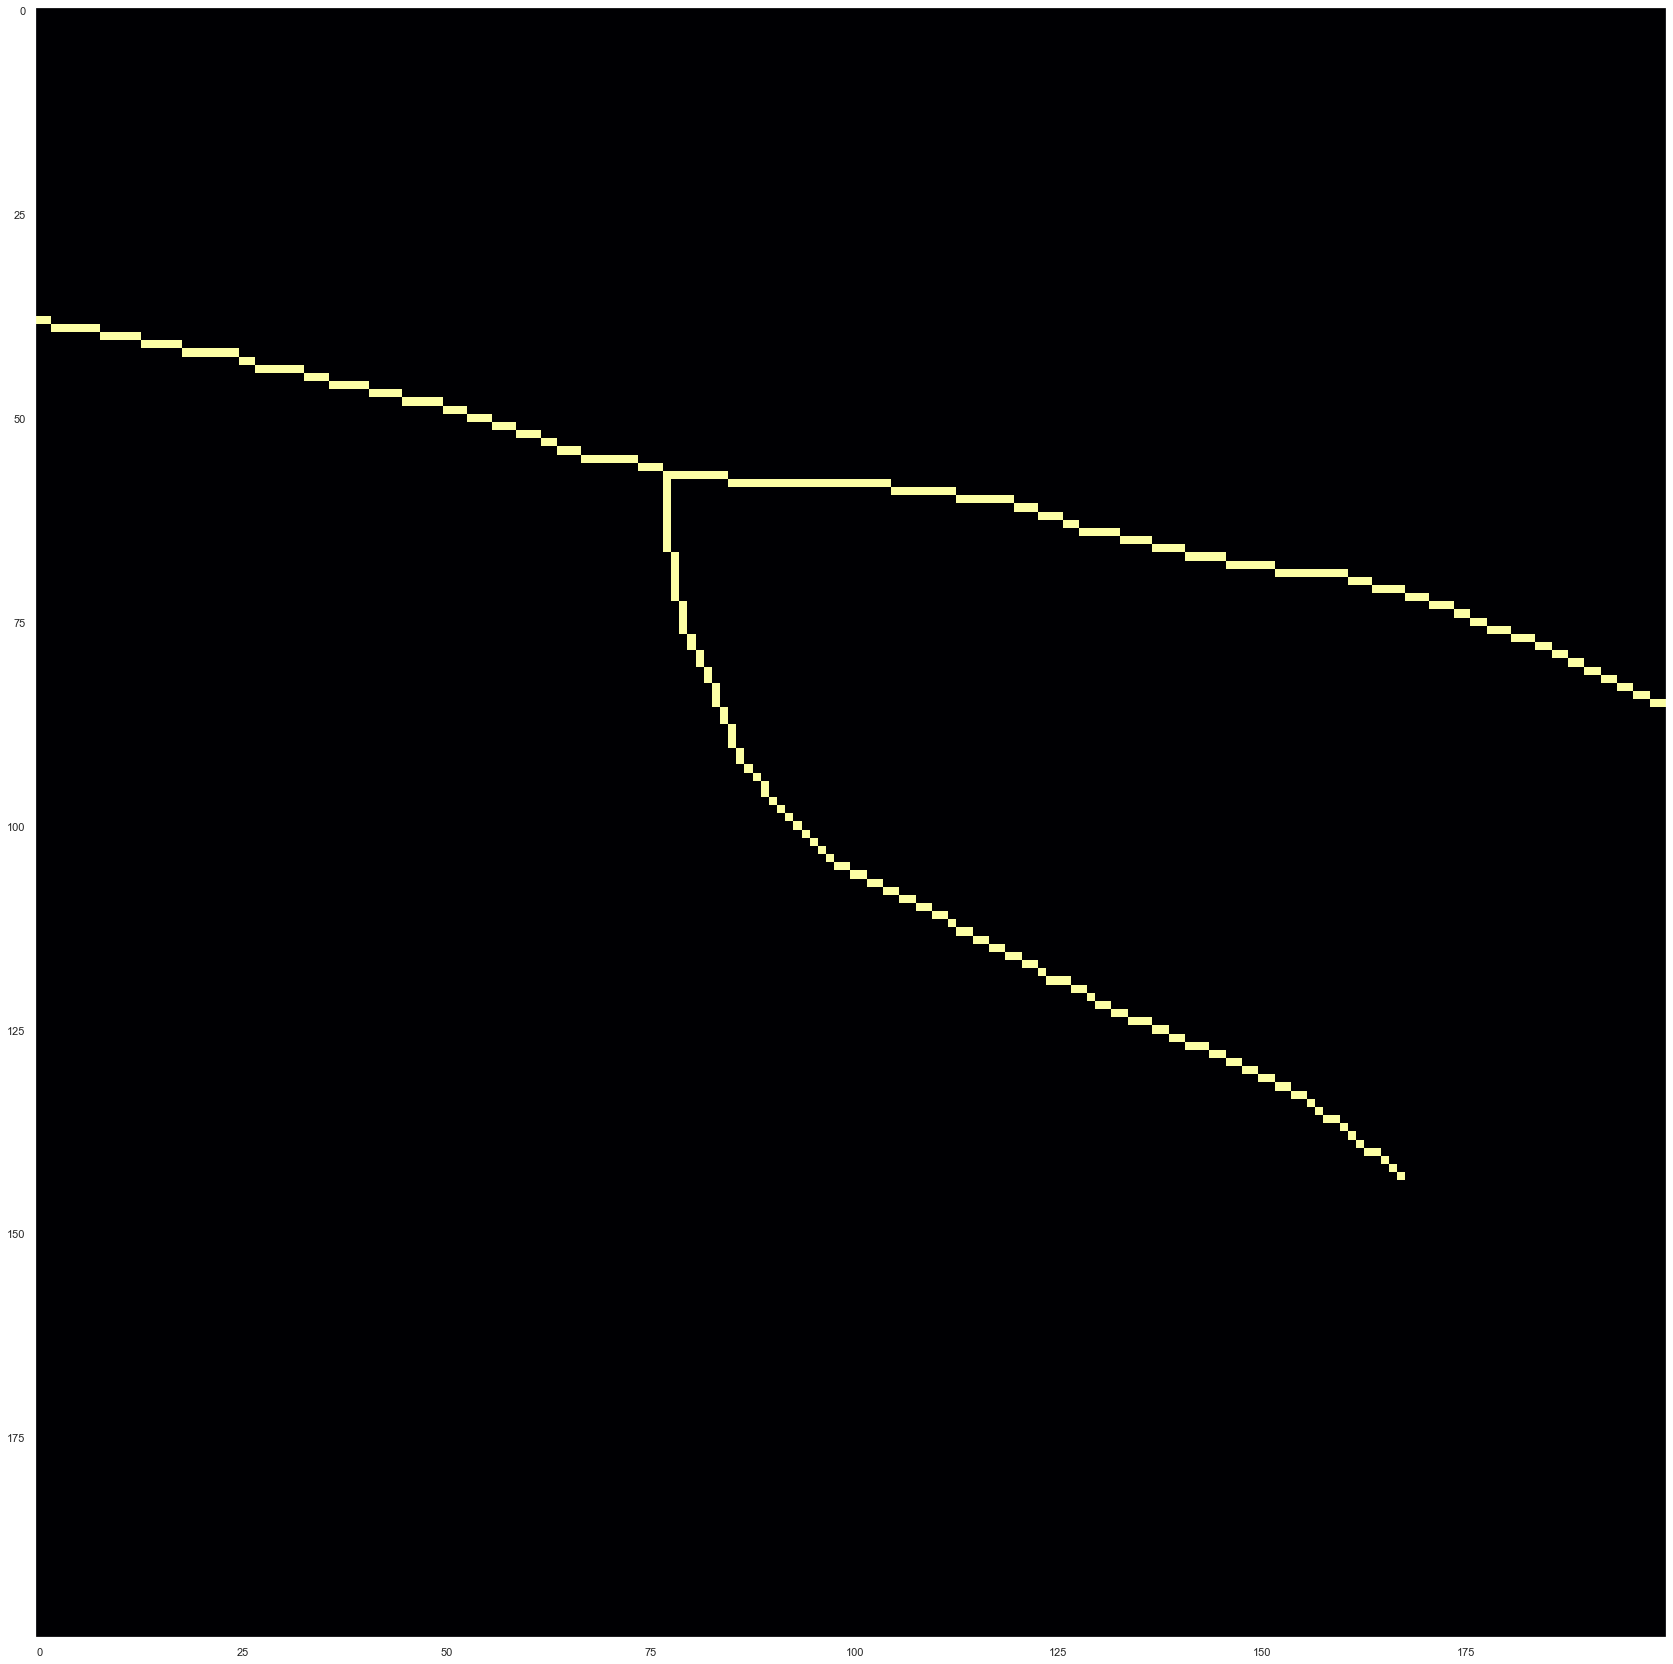

In [72]:

f, ax = plt.subplots(figsize=[40,30])

ax.imshow(ske_small, cmap="inferno", interpolation="none")
plt.grid(None)

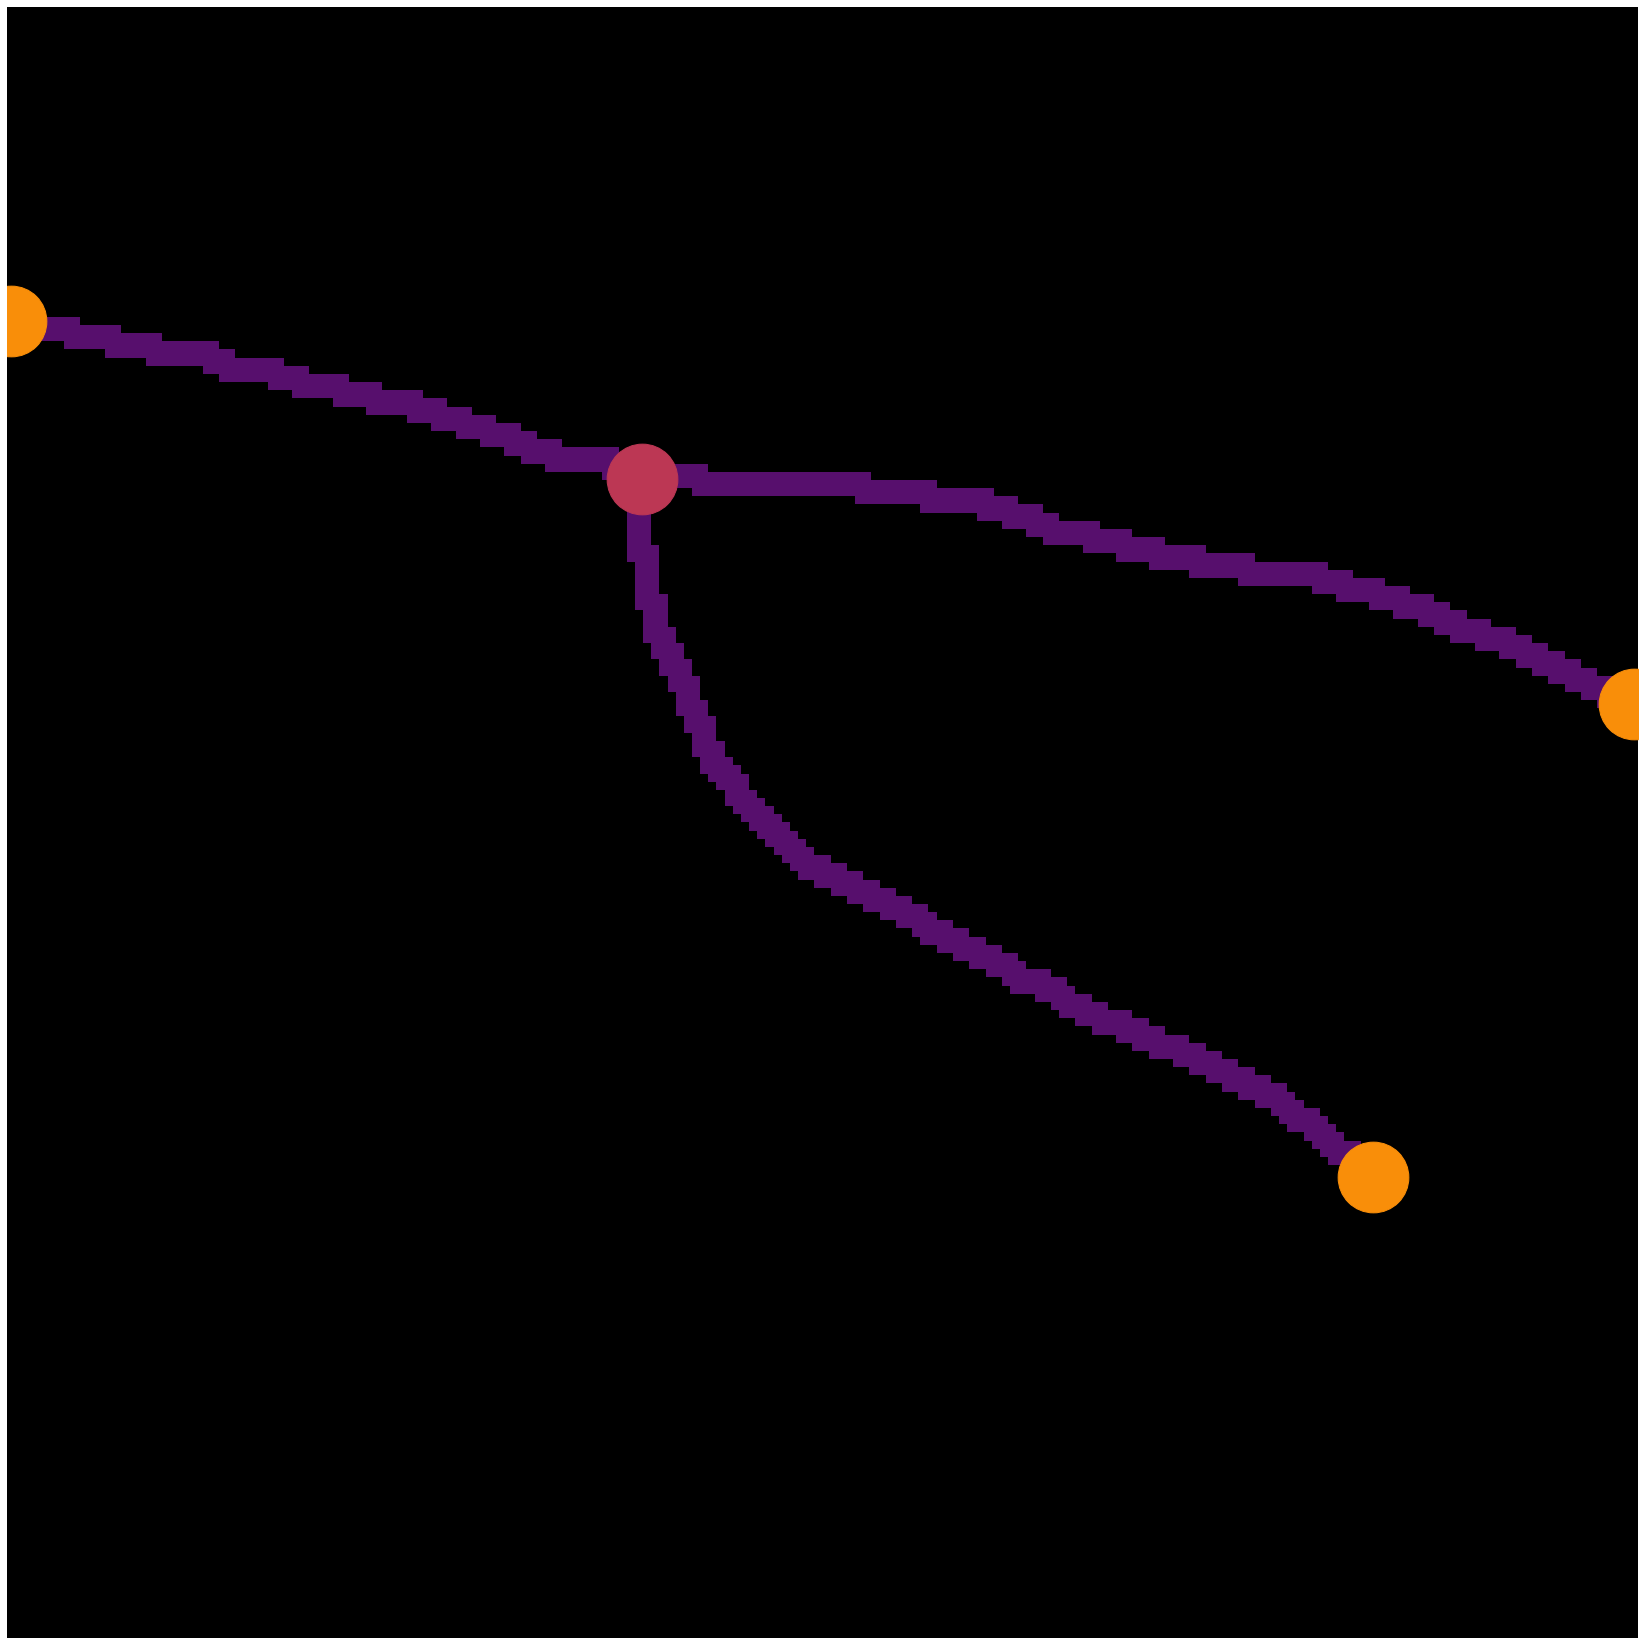

In [81]:
import sknw
import matplotlib

colors = sns.color_palette("inferno", 3)

# build graph from skeleton
graph = sknw.build_sknw(ske_small)

plt.figure(figsize=[40,30])

# draw image
plt.imshow(morphology.binary_dilation(ske_small, selem=morphology.square(3)), 
           cmap = matplotlib.colors.ListedColormap(['black', colors[0]]), interpolation=None)

# draw edges by pts
#for (s,e) in graph.edges():
#    current_ps = graph[s][e]['pts']
#    plt.plot(current_ps[:,1], current_ps[:,0], color=colors[0])
    
# draw node by o
nodes = graph.nodes()
bs = np.array([nodes[i]['o'] for i in nodes if len(graph.edges(i))>=3])
ts = np.array([nodes[i]['o'] for i in nodes if len(graph.edges(i))<=2])
plt.scatter(bs[:,1], bs[:,0], color=colors[1], s=5000)
plt.scatter(ts[:,1], ts[:,0], color=colors[2], s=5000)

plt.axis('off')

# title and show
#plt.title('Build Graph')
plt.show()